# Vehicle Detection using Classical Computer Vision Techniques

The goals / steps of this project are the following:

- Demonstrate the benefits of Histogram of color as a feature in vehicle detection.
- Demonstrate the benefits of Spacial Bins as a feature in vehicle detection.
- Demonstrate the benefits of HOG-Histogram of Oriented Gradients as a feature in vehicle detection.
- Visualize the benifits of normalization
- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier - Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected. Soure(2)

# Introduciton

The main three steps cycle in robotics are perception, decision making and action. It can be said that the most important step in building autonomous vehicles is perception. Computer vision is the art and science of perceiving the world through images. In autonomous vehicles, computer vision can help us detect lane markings, pedestrians, other vehicles and can give us the understanding about the environment in order to navigate safely. In this project we focus on detecting the vehicles arounfd an autonomous car, using images captured. This time, we opted to use classical computer vision techniques to detect vehicles. These techniques were HOG-Histogram of Oriented Gradients, Spatial Bins and Histogram of color. Code is also part of this write up. 

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from scipy.ndimage import maximum,minimum,find_objects,maximum_position,minimum_position
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
# scikit_image HOG :Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [183]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    


In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



In [6]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


Here, I am defining a function which is slightly different then the funciton above. It can take a list of xy_window sizes. It also required y_start_stop_list and length of both lists is required to be same. The idea here is to be able to first get the multi-scale windows.

In [76]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def my_slide_window(img, x_start_stop=[None, None], y_start_stop_list=[[None, None],[None, None]], 
                    xy_windows=[(80, 80),(96, 96)], xy_overlap=(0.5, 0.5)):
    
    window_list = []
    
    if(len(y_start_stop_list)!=len(xy_windows)):
        print("list of y dimensions should be equal to len of xy_windows")
        return window_list
    
    for i in range(len(xy_windows)):
        
        xy_window = xy_windows[i]
        y_start_stop = y_start_stop_list[i] 
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]

        
        
        
    # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_windows = np.int(xspan/nx_pix_per_step) - 1
        ny_windows = np.int(yspan/ny_pix_per_step) - 1
        # Initialize a list to append window positions to

        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [8]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [9]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))   
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features , hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        
    
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return img_features,hog_image
    else:
        return np.concatenate(img_features)


In [10]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In the function below, I am adding the code to generate heatmap for the bounding boxes with positive detection.

In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def my_search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    heatmap = np.zeros_like(img[:,:,0])

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            heatmap[window[0][1]:window[1][1],window[0][0]:window[1][0]] += 1
    

    #8) Return windows for positive detections
    return on_windows,heatmap


In [12]:
def visualize(fig, rows, cols, imgs, titles):
    for i,img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        #plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            

In [13]:
def convert_color(image,conversion='RGB2YCrCb'):
    if conversion == 'RGB2YCrCB':
        return cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
    if conversion == 'BGR2YCrCB':
        return cv2.cvtColor(image,cv2.COLOR_BGR2YCrCb)
    if conversion == 'RGB2LUV':
        return cv2.cvtColor(image,cv2.COLOR_RGB2LUV)

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

In [15]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [16]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Importing Data

In [18]:
vehicle_basedir  = 'vehicles/'

image_types = os.listdir(vehicle_basedir)
cars = []

for imtype in image_types:
    cars.extend(glob.glob(vehicle_basedir+imtype+'/*'))
    
print('Number of Vehicle Images found:', len(cars))
with open("cars.txt",'w') as f:
    for fn in cars:
        f.write(fn+'\n')


Number of Vehicle Images found: 8792


In [19]:
non_vehicle_basedir  = 'non-vehicles/'

image_types = os.listdir(non_vehicle_basedir)
notcars = []

for imtype in image_types:
    notcars.extend(glob.glob(non_vehicle_basedir+imtype+'/*'))
    
print('Number of Non-Vehicle Images found:', len(notcars))
with open("notcars.txt",'w') as f:
    for fn in notcars:
        f.write(fn+'\n')


Number of Non-Vehicle Images found: 8968


## Example of Vehicle and Non-Veehicle Images

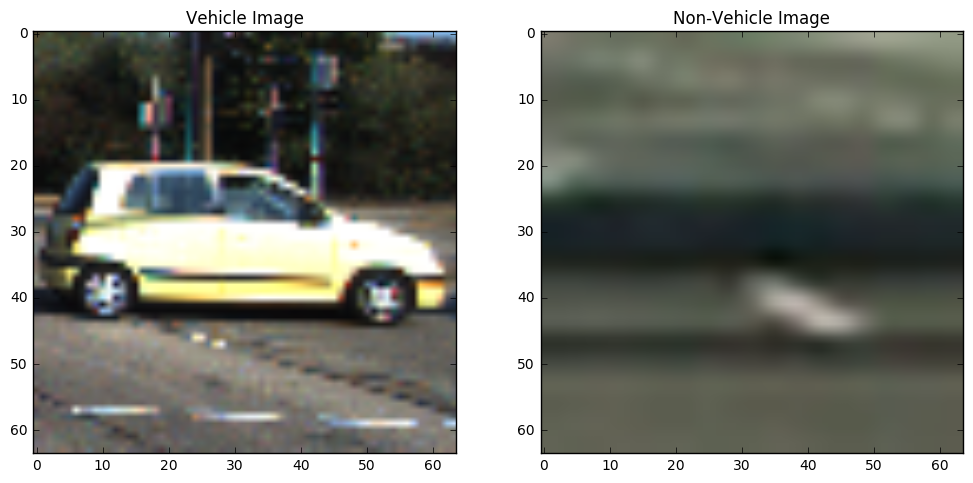

In [160]:
out_images = []
out_titles = []

car_image = mpimg.imread(cars[np.random.randint(0, len(cars))])
out_images.append(car_image)
out_titles.append("Vehicle Image")

not_car_image = mpimg.imread(notcars[np.random.randint(0, len(notcars))])
out_images.append(not_car_image)
out_titles.append("Non-Vehicle Image")

fig = plt.figure(figsize=(12,24),dpi=300)
visualize(fig,2,2,out_images,out_titles)

#### I tried different color spaces(HLS, LUV and YCrCb), YCrCb performed better in term of accuracy using Linear SVM. So, for extracting feature I will be showing my work using YCrCb.

For HOG, I tried different parameter values. At the end I am using these values.
- orientations: 9
- pixels per cell: 8
- cells per block :2
- channels : ALL


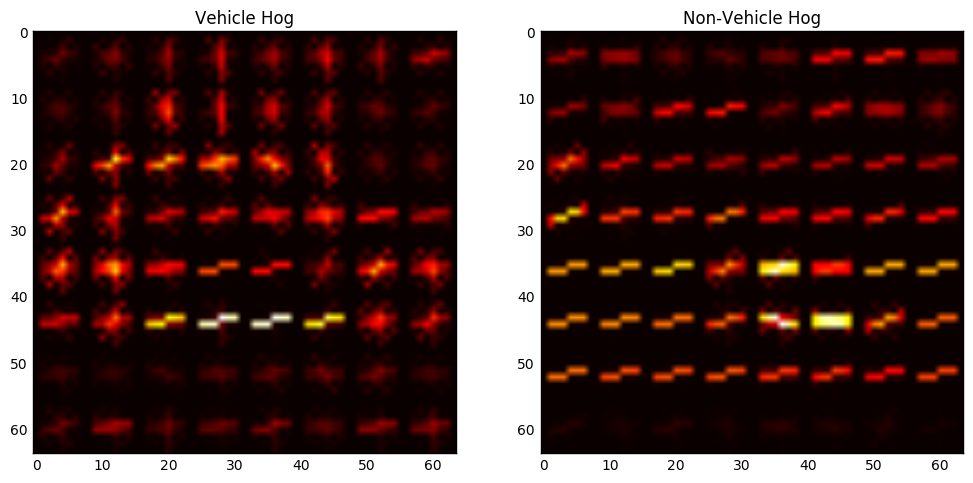

In [166]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

out_images = []
out_titles = []

gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
car_hog_features, car_hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

out_images.append(car_hog_image)
out_titles.append("Vehicle Hog")

gray = cv2.cvtColor(not_car_image, cv2.COLOR_RGB2GRAY)
not_car_hog_features, not_car_hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

out_images.append(not_car_hog_image)
out_titles.append("Non-Vehicle Hog")

fig = plt.figure(figsize=(12,24))
visualize(fig,1,2,out_images,out_titles)

#### For spatial binning dimensions used are 32x32 and color space is 'YCrCb'

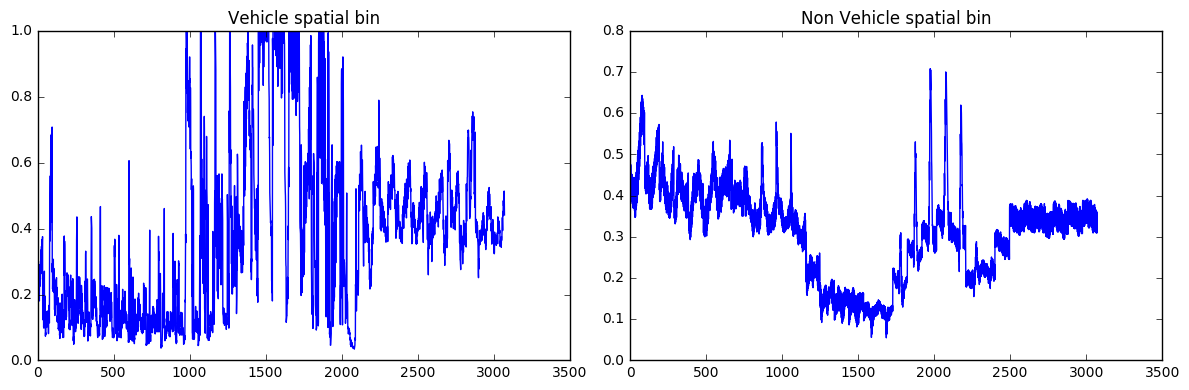

In [169]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32) # Spatial binning dimensions

car_bin_spatial_features = bin_spatial(car_image, color_space=color_space, size=spatial_size)

not_car_bin_spatial_features = bin_spatial(not_car_image, color_space=color_space, size=spatial_size)


fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(car_bin_spatial_features)
plt.title("Vehicle spatial bin")

plt.subplot(122)
plt.plot(not_car_bin_spatial_features)
plt.title("Non Vehicle spatial bin")


fig.tight_layout()

## Training the Linear SVM Classifier
#### Function extract_features defined above is used here to claculate and normalize spatial, histogram and HOG feautres

In [20]:
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

t=time.time()
n_samples = 1000
random_indxs = np.random.randint(0,len(cars),n_samples)
test_cars = cars#np.array(cars)[random_indxs]
test_notcars = notcars#np.array(notcars)[random_indxs]

car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t,' Seconds to compute features...')


128.24714708328247  Seconds to compute features...


In [21]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample





Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
6.53 Seconds to train SVC...
Test Accuracy of SVC =  0.991


## Sliding Window Search

The next important step was to make a strategy to extract patches from an image to check if these represent a vehicle or not. 
- After spending a lot of time experimenting, multi scale windows are used to extract patches. The main reason is that car appears in different sizes dependent on how far these are. Some cars are bigger in some frames and others are small. That is the reason this multisclae approach is used. 
- Also, different focus areas are used for different window sizes.
- Overlapping is kept to 0.5, experimented with higher overlaps like 0.8,0.9 which resulted in a lot of windows but not a lot of benefit as it increased the processing time a lot. 
- Along x-axis, whole width is used as car can be in different lanes so it is important that it is considering the right most lane or left most lane etc. 
    - Window Size: (80,70)       Image Area: (400,540)    Overlap: 0.5  ---> Total Images: 93
    - Window Size: (96,96)       Image Area: (400,656)    Overlap: 0.5  ---> Total Images: 100
    - Window Size: (115,105)     Image Area: (480,595)    Overlap: 0.5  ---> Total Images: 21
    - Window Size: (150,140)     Image Area: (400,680)    Overlap: 0.5  ---> Total Images: 48
    - Total Number of windows : 93+100+21+48 = 262


262


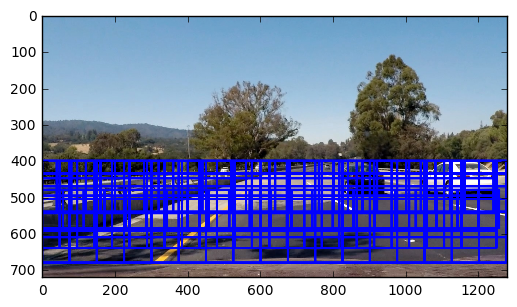

In [180]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = my_slide_window(image, x_start_stop=[None, None], y_start_stop_list= [[400, 540],[400,656],[480,595],[400,680]], 
                            xy_windows=[(80, 70),(96,96),(115,105),(150,140)], xy_overlap=(0.5, 0.5))
print(len(windows))                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### Finding the cars
- Heatmap functionality was added in my_search_windows(), second last line
- For an individual image, thesholding is not used
- For videos find_cars() is used, performance is optimized by storing heatmpas of last 20 frames in a queue(global variable)
- After adding heatmaps all the frames, a threshold of 5 is used to filter flase positives
- Results of testing it on image and videos are shared below. 
- Video Link: https://youtu.be/2n5B8RY2u8I

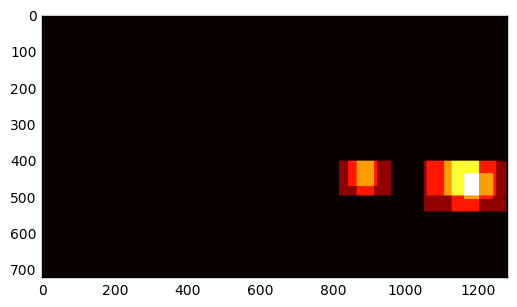

In [185]:
import collections
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = my_slide_window(image, x_start_stop=[None, None], y_start_stop_list= [[400, 540],[400,656],[480,595],[400,680]], 
                            xy_windows=[(80, 70),(96,96),(115,105),(150,140)], xy_overlap=(0.5, 0.5))

hot_windows,heatmap = my_search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

plt.imshow(heatmap,cmap='hot')

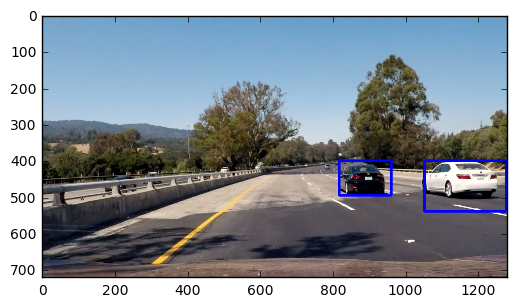

In [186]:
window_img= draw_labeled_bboxes(draw_image, label(heatmap))                   
plt.imshow(window_img)

In [148]:
import collections
my_heatmap = np.zeros_like(window_img[:,:,0])
global_last_20 = collections.deque(20*my_heatmap, maxlen = 20)

def find_cars(image):
    
        
    draw_image = np.copy(image)
    new_heatmap = np.zeros_like(draw_image[:,:,0])
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = my_slide_window(image, x_start_stop=[None, None], y_start_stop_list= [[400, 540],[400,656],[480,595],[400,680]], 
                            xy_windows=[(80, 70),(96,96),(115,105),(150,140)], xy_overlap=(0.5, 0.5))
    len(windows)
    hot_windows,heatmap = my_search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    global_last_20.appendleft(heatmap)
    last_20_list = list(global_last_20)
    
    for i in range(len(last_20_list)):
        new_heatmap +=np.uint8(last_20_list[i]) 
        
    new_heatmap = apply_threshold(new_heatmap,5)
    window_img= draw_labeled_bboxes(draw_image, label(new_heatmap))     
    return window_img

In [130]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [146]:
test_output = 'test.mp4'
clip = VideoFileClip('test_video.mp4')
test_clip = clip.fl_image(find_cars)
test_clip.write_videofile(test_output,audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


 97%|█████████▋| 38/39 [01:00<00:01,  1.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



In [147]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [149]:
project_output = 'project.mp4'
clip = VideoFileClip('project_video.mp4')
project_clip = clip.fl_image(find_cars)
project_clip.write_videofile(project_output,audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████▉| 1260/1261 [34:23<00:01,  1.61s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 



In [150]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Final Thoughts
- There is room for improvement, for example:
    - Bounding boxes are bigger then the cars, I think there should be tight bounding for the boxes. Currently it will result in wrong understanding of car position.
    - I feel that white car is less detected by the classifier as compared to black car. In future I will do more data exploration, in this direction
    - Results might not be good in different lighting conditions for example at night. A different strategy should be used for that. For example, using the car lights at the back or side to detect vehicles. 
    - Vertically, a horizon is specified so if a car is climbing a hill, some cars might not be detected properly. 